<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/Simple_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import prophet
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
def model_performance(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape = MAPE(y_true, y_pred)
  return f"RMSE: {rmse}, MAPE: {mape}"

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', parse_dates = ['date'], index_col = ['date'])

In [ ]:
# Simple Prophet
# Group by contries

In [5]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [6]:
train = train[['country_code', 'new_confirmed']]
test = test[['country_code', 'new_confirmed']]

In [7]:
# group by countries
train_country = train.groupby(['country_code','date'])
test_country = test.groupby(['country_code','date'])
train_country_agg = train_country.agg('sum')
train_country_agg.reset_index(level = 'country_code', inplace = True)
test_country_agg = test_country.agg('sum')
test_country_agg.reset_index(level = 'country_code', inplace = True)

In [8]:
# Use US as a representative
US_train = train_country_agg.loc[train_country_agg.country_code == 'US','new_confirmed']
US_test = test_country_agg.loc[test_country_agg.country_code == 'US','new_confirmed']

In [9]:
US_train = US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
US_test = US_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})

In [10]:
# fit a prophet model
model_US = prophet.Prophet().fit(US_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxhnsxyn/mo6hla24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxhnsxyn/yxiiudue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36055', 'data', 'file=/tmp/tmprxhnsxyn/mo6hla24.json', 'init=/tmp/tmprxhnsxyn/yxiiudue.json', 'output', 'file=/tmp/tmprxhnsxyn/prophet_modelafil9z4c/prophet_model-20231209035201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
US_train_predict = model_US.predict(US_train)
US_train_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,-7091.695856,-107063.210251,34811.574352,-7091.695856,-7091.695856,-26784.159425,-26784.159425,-26784.159425,-26784.159425,-26784.159425,-26784.159425,0.0,0.0,0.0,-33875.855281
1,2020-03-02,-6671.097813,-66084.009231,66755.169331,-6671.097813,-6671.097813,11625.748422,11625.748422,11625.748422,11625.748422,11625.748422,11625.748422,0.0,0.0,0.0,4954.650609
2,2020-03-03,-6250.499770,-71018.482770,66420.420800,-6250.499770,-6250.499770,2182.497273,2182.497273,2182.497273,2182.497273,2182.497273,2182.497273,0.0,0.0,0.0,-4068.002496
3,2020-03-04,-5829.901727,-62338.993541,71480.431136,-5829.901727,-5829.901727,9759.604420,9759.604420,9759.604420,9759.604420,9759.604420,9759.604420,0.0,0.0,0.0,3929.702693
4,2020-03-05,-5409.303684,-71718.400079,72975.313956,-5409.303684,-5409.303684,7842.701919,7842.701919,7842.701919,7842.701919,7842.701919,7842.701919,0.0,0.0,0.0,2433.398235


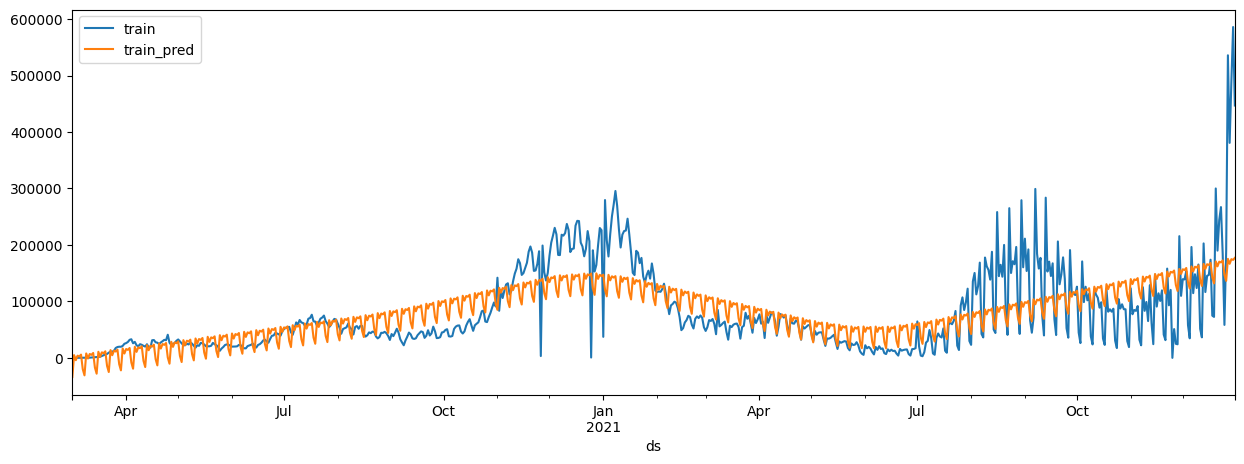

In [12]:
# make the date the index column for y_train and y_train_predict
US_train_predict_y = US_train_predict[['ds','yhat']].set_index('ds')
US_train_date_index = US_train.set_index('ds')
pd.concat([US_train_date_index,US_train_predict_y], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

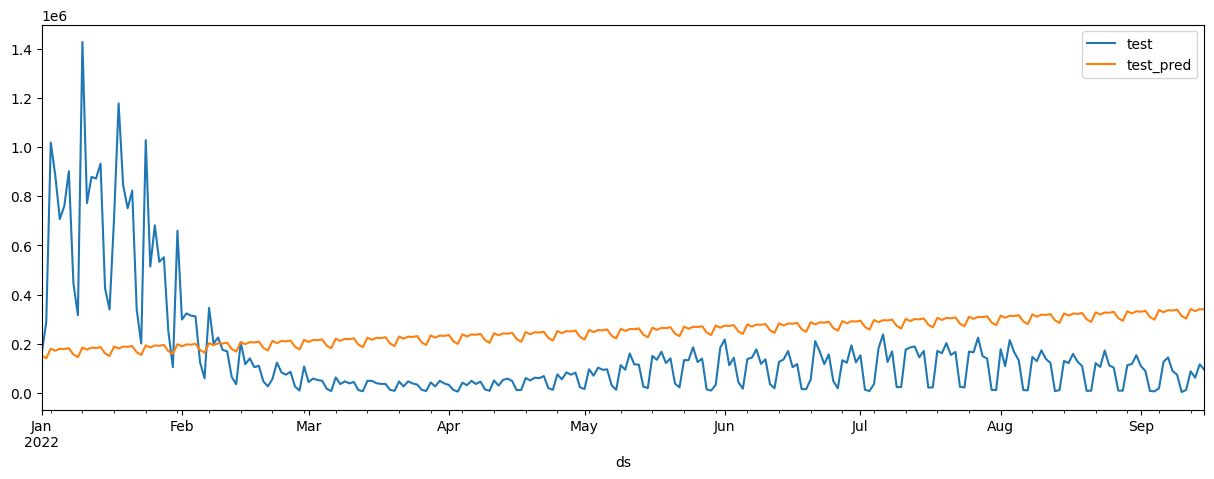

In [13]:
# predict the testing data
US_test_predict = model_US.predict(US_test)
US_test_predict_y = US_test_predict[['ds','yhat']].set_index('ds')
US_test_date_index = US_test.set_index('ds')
pd.concat([US_test_date_index,US_test_predict_y], axis=1).plot(figsize=(15,5))
plt.legend(['test', 'test_pred'])

In [15]:
# training data
model_performance(US_train_date_index, US_train_predict_y)

'RMSE: 53767.8273060866, MAPE: 1018.6555844666588'

In [16]:
# testing data
model_performance(US_test_date_index, US_test_predict_y)

'RMSE: 261758.29865836527, MAPE: 609.124590481856'

In [17]:
# Fit a model for each country

train_pred = train_country_agg.copy()
train_pred.new_confirmed = None
train_pred.columns = ['country_code','predicted_new_confirmed']
train_pred.reset_index(inplace = True)
train_pred['date'] = pd.to_datetime(train_pred['date'])

test_pred = test_country_agg.copy()
test_pred.new_confirmed = None
test_pred.columns = ['country_code','predicted_new_confirmed']
test_pred.reset_index(inplace = True)


In [18]:
start_time = time.time()

loc_list = list(train_country_agg.country_code.unique())

for loc in loc_list:
  # initialize the dataset
  train_interest = train_country_agg.loc[train_country_agg.country_code == loc, 'new_confirmed'] # select the rows in the training data
  test_interest = test_country_agg.loc[test_country_agg.country_code == loc, 'new_confirmed'] # select the rows in the testing data
  train_interest = train_interest.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
  test_interest = test_interest.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
  # fit the model on the train dataset
  model = prophet.Prophet().fit(train_interest)
  pred_for_train = model.predict(train_interest)
  for date in pred_for_train.ds:
    train_pred.loc[(train_pred.country_code == loc) & (train_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_train.loc[pred_for_train.ds == date, 'yhat'])
  # predict test dataset
  pred_for_test = model.predict(test_interest)
  for date in pred_for_test.ds:
    test_pred.loc[(test_pred.country_code == loc) & (test_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_test.loc[pred_for_test.ds == date, 'yhat'])

print("Time taken = ", round((time.time()-start_time)/60), " minutes")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxhnsxyn/l4n2pgd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxhnsxyn/9yb4g3j3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80759', 'data', 'file=/tmp/tmprxhnsxyn/l4n2pgd8.json', 'init=/tmp/tmprxhnsxyn/9yb4g3j3.json', 'output', 'file=/tmp/tmprxhnsxyn/prophet_modeljm6aac4d/prophet_model-20231209035926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:59:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Time taken =  0  minutes


In [19]:
test_pred

,date,country_code,predicted_new_confirmed
0,2022-01-01,AU,207.430916
1,2022-01-02,AU,210.391912
2,2022-01-03,AU,213.077906
3,2022-01-04,AU,216.899044
4,2022-01-05,AU,223.948458
...,...,...,...
2565,2022-09-11,US,302115.613458
2566,2022-09-12,US,341165.559849
2567,2022-09-13,US,332362.347245
2568,2022-09-14,US,340579.492935


In [20]:
train_pred

,date,country_code,predicted_new_confirmed
0,2020-03-01,AU,8.542387
1,2020-03-02,AU,9.464523
2,2020-03-03,AU,11.521802
3,2020-03-04,AU,16.807357
4,2020-03-05,AU,18.843823
...,...,...,...
6600,2021-12-27,US,175395.576897
6601,2021-12-28,US,166592.364293
6602,2021-12-29,US,174809.509984
6603,2021-12-30,US,173532.646027


In [23]:
print("the rmse on the training data is ", mean_squared_error(train_country_agg.new_confirmed, train_pred.predicted_new_confirmed, squared = False))
print("the rmse on the testing data is ", mean_squared_error(test_country_agg.new_confirmed, test_pred.predicted_new_confirmed, squared = False))

the rmse on the training data is  17162.5836899578
the rmse on the testing data is  83536.5423035693
